In [41]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import os
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
import math
from PIL import Image
from rasterio.transform import from_origin



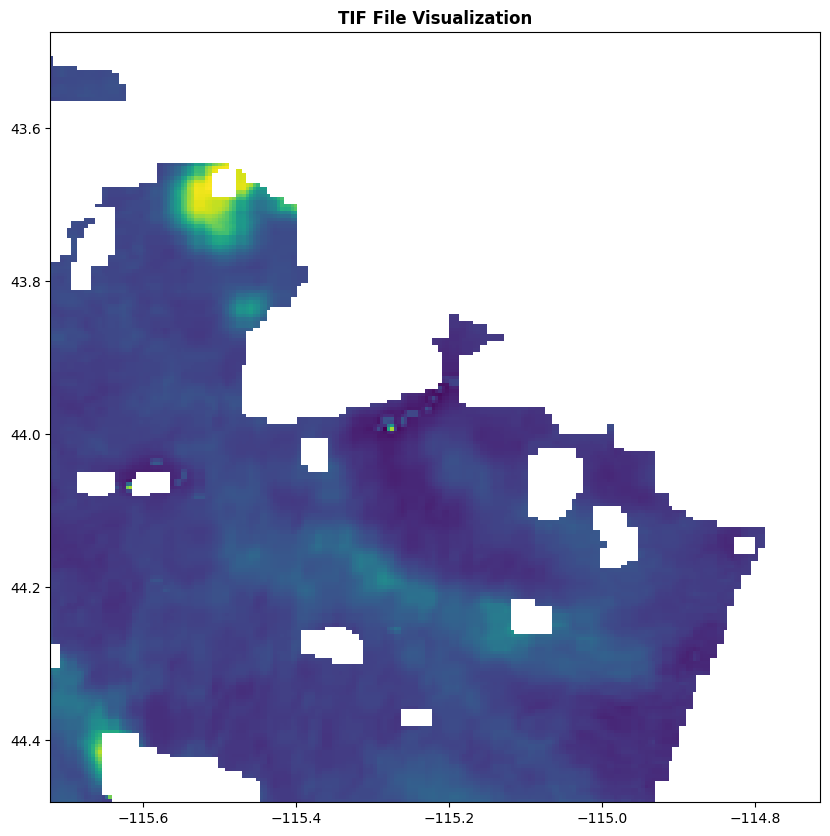

In [43]:
tif_file_path = "Dataset/test_new/SMAP_2019-01-31.tif"


with rasterio.open(tif_file_path) as src:
    fig, ax = plt.subplots(figsize=(10, 10))
    show(src, ax=ax, title="TIF File Visualization")
    plt.show()


In [23]:

class SoilDataset(Dataset):
    def __init__(self, directory, split='train', sequence_length=30, transform=None, nan_replacement=0):
        self.sequence_length = sequence_length
        self.file_paths = sorted([os.path.join(directory, split, f) for f in os.listdir(os.path.join(directory, split)) if f.endswith('.tif')],
                                 key=lambda x: datetime.strptime(os.path.basename(x).split('_')[1].split('.')[0], '%Y-%m-%d'))
        self.data, self.min_max = self._load_data()
        self.transform = transform

    def _load_data(self):
        data = []
        min_max = []
        for file_path in self.file_paths:
            date_str = os.path.basename(file_path).split('_')[1].split('.')[0]
            date = datetime.strptime(date_str, '%Y-%m-%d')
            with rasterio.open(file_path) as src:
                img = src.read(1).astype(np.float32)
                
                # Handle NaN values
                img[np.isnan(img)] = 0.0 
                
                data.append(img)
                min_val, max_val = img.min(), img.max()
                min_max.append((min_val, max_val))
        return data, min_max
    
    def __len__(self):
        return len(self.data) - self.sequence_length
    
    def __getitem__(self, index):
        x_start = index
        x_end = index + self.sequence_length
        
        # Input sequence
        x = [self.data[i] for i in range(x_start, x_end)]
        
        # Target sequence
        y_index = x_end
        y = self.data[y_index]
        
        # Normalize input sequence
        # for i in range(len(x)):
        #     min_val, max_val = self.min_max[x_start + i]
        #     x[i] = (x[i] - min_val) / (max_val - min_val)
        
        # # Normalize target image
        # min_val, max_val = self.min_max[y_index]
        # y = (y - min_val) / (max_val - min_val)

        x = np.stack(x, axis=0)
        x = torch.from_numpy(x).float()
        y = torch.from_numpy(y).float().unsqueeze(0)  # Adding channel 
        input_file_paths = [os.path.basename(self.file_paths[i]).split('_')[1].split('.')[0] for i in range(x_start, x_end)]
       
        target_file_path = os.path.basename(self.file_paths[y_index]).split('_')[1].split('.')[0]  # Include file path for both input and target
        
        return x, y,input_file_paths,target_file_path

# Directory containing train, valid, and test folders
directory = 'Dataset'

# Define datasets and data loaders for train, valid, and test sets
train_dataset = SoilDataset(directory, split='train_new',nan_replacement=0)
valid_dataset = SoilDataset(directory, split='valid_new')
test_dataset = SoilDataset(directory, split='test_new')

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Testing the dataloaders
for x, y,_,_ in train_dataloader:
    print("Train:", x.shape, y.shape)
    break

for x, y,_,_  in valid_dataloader:
    print("Valid:", x.shape, y.shape)
    break

for x, y,_,_  in test_dataloader:
    print("Test:", x.shape, y.shape)
    break


Train: torch.Size([4, 30, 224, 224]) torch.Size([4, 1, 224, 224])
Valid: torch.Size([4, 30, 224, 224]) torch.Size([4, 1, 224, 224])
Test: torch.Size([4, 30, 224, 224]) torch.Size([4, 1, 224, 224])


In [18]:
def window_partition(x, window_size):
    B, H, W, C = x.shape
    x = x.view(B, H // window_size[0], window_size[0], W // window_size[1], window_size[1], C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size[0], window_size[1], C)
    return windows

def window_reverse(windows, window_size, H, W):
    C = windows.shape[-1]
    x = windows.view(-1, H // window_size[0], W // window_size[1], window_size[0], window_size[1], C)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, H, W, C)
    return x

def get_relative_position_index(win_h: int, win_w: int):
    # get pair-wise relative position index for each token inside the window
    coords = torch.stack(torch.meshgrid(torch.arange(win_h), torch.arange(win_w),indexing='ij'))  # 2, Wh, Ww
    coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
    relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
    relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
    relative_coords[:, :, 0] += win_h - 1  # shift to start from 0
    relative_coords[:, :, 1] += win_w - 1
    relative_coords[:, :, 0] *= 2 * win_w - 1
    return relative_coords.sum(-1)  # Wh*Ww, Wh*Ww

class WindowAttention(nn.Module):
    def __init__(
            self,
            dim,
            window_size,
    ):
        super().__init__()
        self.window_size = window_size
        self.window_area = self.window_size[0]*self.window_size[1]
        self.num_heads = 4
        head_dim =  dim // self.num_heads
        # attn_dim = head_dim * self.num_heads
        self.scale = head_dim ** -0.5

        self.relative_position_bias_table = nn.Parameter(torch.zeros((2 * window_size[0] - 1) **2, self.num_heads))

        # get pair-wise relative position index for each token inside the window
        self.register_buffer("relative_position_index", get_relative_position_index(self.window_size[0], self.window_size[1]), persistent=False)

        self.qkv = nn.Linear(dim, dim * 3)
        self.proj = nn.Linear(dim, dim)

        torch.nn.init.trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def _get_rel_pos_bias(self):
        relative_position_bias = self.relative_position_bias_table[
            self.relative_position_index.view(-1)].view(self.window_area, self.window_area, -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        return relative_position_bias.unsqueeze(0)

    def forward(self, x, mask = None):
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, -1).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)


        q = q * self.scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + self._get_rel_pos_bias()
        if mask is not None:
            num_win = mask.shape[0]
            attn = attn.view(-1, num_win, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
        attn = self.softmax(attn)
        x = attn @ v

        x = x.transpose(1, 2).reshape(B_, N, -1)
        x = self.proj(x)
        return x

In [17]:
class SwinTransformerBlock(nn.Module):
    def __init__(
            self,  dim, input_resolution, window_size = 7, shift_size = 0):

        super().__init__()
        self.input_resolution = input_resolution
        window_size = (window_size, window_size)
        shift_size = (shift_size, shift_size)
        self.window_size = window_size
        self.shift_size = shift_size
        self.window_area = self.window_size[0] * self.window_size[1]

        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(
            dim,
            window_size=self.window_size,
        )

        self.norm2 = nn.LayerNorm(dim)

        self.mlp = nn.Sequential(
            nn.Linear(dim, 4 * dim),
            nn.GELU(),
            nn.LayerNorm(4 * dim),
            nn.Linear( 4 * dim, dim)
        )

        if self.shift_size:
            # calculate attention mask for SW-MSA
            H, W = self.input_resolution
            H = math.ceil(H / self.window_size[0]) * self.window_size[0]
            W = math.ceil(W / self.window_size[1]) * self.window_size[1]
            img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
            cnt = 0
            for h in (
                    slice(0, -self.window_size[0]),
                    slice(-self.window_size[0], -self.shift_size[0]),
                    slice(-self.shift_size[0], None)):
                for w in (
                        slice(0, -self.window_size[1]),
                        slice(-self.window_size[1], -self.shift_size[1]),
                        slice(-self.shift_size[1], None)):
                    img_mask[:, h, w, :] = cnt
                    cnt += 1
            mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
            mask_windows = mask_windows.view(-1, self.window_area)
            attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
            attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask, persistent=False)

    def _attn(self, x):
        B, H, W, C = x.shape

        # cyclic shift
        if self.shift_size:
            shifted_x = torch.roll(x, shifts=(-self.shift_size[0], -self.shift_size[1]), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_area, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size[0], self.window_size[1], C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C
        shifted_x = shifted_x[:, :H, :W, :].contiguous()

        # reverse cyclic shift
        if self.shift_size:
            x = torch.roll(shifted_x, shifts=self.shift_size, dims=(1, 2))
        else:
            x = shifted_x
        return x

    def forward(self, x):
        B, H, W, C = x.shape
        B, H, W, C = x.shape
        x = x + self._attn(self.norm1(x))
        x = x.reshape(B, -1, C)
        x = x + self.mlp(self.norm2(x))
        x = x.reshape(B, H,W, C)
        return x

In [16]:
class PatchEmbedding(nn.Module):
    def __init__(self, seq_len, C, patch_size):
        super().__init__()
        self.conv = nn.Conv2d(seq_len,C, kernel_size=patch_size,
                                  stride=patch_size)

    def forward(self, X):
        # Output shape: (batch size, no. of patches, no. of channels)
        return self.conv(X).permute(0,2,3,1)

class PatchMerging(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(4 * dim)
        self.reduction = nn.Linear(4*dim, 2*dim, bias=False)

    def forward(self, x):
        B, H, W, C = x.shape
        x = x.reshape(B, H // 2, 2, W // 2, 2, C).permute(0, 1, 3, 4, 2, 5).flatten(3)
        x = self.norm(x)
        x = self.reduction(x)
        return x

class PatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim//2)
        self.expand = nn.Linear(dim, 2*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 2, 2, C//4)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*2, W*2 , C//4)

        x = self.norm(x)
        return x

class FinalPatchExpansion(nn.Module):

    def __init__(
            self,
            dim
    ):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.expand = nn.Linear(dim, 16*dim, bias=False)

    def forward(self, x):

        x = self.expand(x)
        B, H, W, C = x.shape

        x = x.view(B, H , W, 4, 4, C//16)
        x = x.permute(0,1,3,2,4,5)

        x = x.reshape(B,H*4, W*4 , C//16)

        x = self.norm(x)
        return x

In [14]:
class SwinBlock(nn.Module):
    def __init__(self, dims, ip_res, ss_size = 3):
        super().__init__()
        self.swtb1 = SwinTransformerBlock(dim=dims, input_resolution=ip_res)
        self.swtb2 = SwinTransformerBlock(dim=dims, input_resolution=ip_res, shift_size=ss_size)

    def forward(self, x):
        return self.swtb2(self.swtb1(x))


class Encoder(nn.Module):
    def __init__(self, C, partioned_ip_res):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.enc_swin_blocks = nn.ModuleList([
            SwinBlock(C, (H, W)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(4*C, (H//4, W//4))
        ])
        self.enc_patch_merge_blocks = nn.ModuleList([
            PatchMerging(C),
            PatchMerging(2*C),
            PatchMerging(4*C)
        ])

    def forward(self, x):
        skip_conn_ftrs = []
        for swin_block,patch_merger in zip(self.enc_swin_blocks, self.enc_patch_merge_blocks):
            x = swin_block(x)
            skip_conn_ftrs.append(x)
            x = patch_merger(x)
        return x, skip_conn_ftrs


class Decoder(nn.Module):
    def __init__(self, C, partioned_ip_res):
        super().__init__()
        H,W = partioned_ip_res[0], partioned_ip_res[1]
        self.dec_swin_blocks = nn.ModuleList([
            SwinBlock(4*C, (H//4, W//4)),
            SwinBlock(2*C, (H//2, W//2)),
            SwinBlock(C, (H, W))
        ])
        self.dec_patch_expand_blocks = nn.ModuleList([
            PatchExpansion(8*C),
            PatchExpansion(4*C),
            PatchExpansion(2*C)
        ])
        self.skip_conn_concat = nn.ModuleList([
            nn.Linear(8*C, 4*C),
            nn.Linear(4*C, 2*C),
            nn.Linear(2*C, 1*C)
        ])

    def forward(self, x, encoder_features):
        for patch_expand,swin_block, enc_ftr, linear_concatter in zip(self.dec_patch_expand_blocks, self.dec_swin_blocks, encoder_features,self.skip_conn_concat):
            x = patch_expand(x)
            x = torch.cat([x, enc_ftr], dim=-1)
            x = linear_concatter(x)
            x = swin_block(x)
        return x


class SwinUNet(nn.Module):
    def __init__(self, H, W, seq_len, C, out_seq, num_blocks=3, patch_size = 4):
        super().__init__()
        self.patch_embed = PatchEmbedding(seq_len, C, patch_size)
        self.encoder = Encoder(C, (H//patch_size, W//patch_size))
        self.bottleneck = SwinBlock(C*(2**num_blocks), (H//(patch_size* (2**num_blocks)), W//(patch_size* (2**num_blocks))))
        self.decoder = Decoder(C, (H//patch_size, W//patch_size))
        self.final_expansion = FinalPatchExpansion(C)
        self.head        = nn.Conv2d(C, out_seq, 1,padding='same')

    def forward(self, x):
        x = self.patch_embed(x)

        x,skip_ftrs  = self.encoder(x)

        x = self.bottleneck(x)

        x = self.decoder(x, skip_ftrs[::-1])

        x = self.final_expansion(x)

        x = self.head(x.permute(0,3,1,2))

        return x

In [45]:
def train_epoch(model, dataloader):
    model.train()
    losses= []
    for x, y,_,_ in dataloader:
        optimizer.zero_grad()
        out = model.forward(x.to(DEVICE))
        loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return np.mean(losses)

def train(model, epochs,  save_path_template, train_dataloader, valid_dataloader):

    for ep in range(epochs):
        train_loss = train_epoch(model, train_dataloader)
        
        # Compute validation loss
        valid_loss = evaluate(model, valid_dataloader)
        
        # Print train and validation loss after every 10 epochs
        if (ep + 1) % 10 == 0:
            print(f'Epoch: {ep+1}: train_loss={train_loss:.5f}, valid_loss={valid_loss:.5f}')
        
        # Save the model after every 10 epochs
        if (ep + 1) % 10 == 0:
            save_path = save_path_template.format(epoch=ep+1)
            torch.save(model.state_dict(), save_path)
        
    return train_loss

def evaluate(model, dataloader):
    model.eval()
    losses = []
    with torch.no_grad():
        for x, y,_,_ in dataloader:
            out = model.forward(x.to(DEVICE))
            loss = loss_fn(out, y.to(DEVICE)).to(DEVICE)
            losses.append(loss.item())
    return np.mean(losses)

In [46]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SwinUNet(H=224,W=224,seq_len=30,C=32,out_seq=1,num_blocks=3,patch_size=4).to(DEVICE)

for p in model.parameters():
    if p.dim() > 1:
            nn.init.kaiming_uniform_(p)

optimizer = torch.optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
save_path_template = 'weights/model_epoch_{epoch}.pth'
train(model, epochs=100, save_path_template=save_path_template,train_dataloader=train_dataloader, valid_dataloader=valid_dataloader)

Epoch: 10: train_loss=0.00250, valid_loss=0.00176
Epoch: 20: train_loss=0.00209, valid_loss=0.00170
Epoch: 30: train_loss=0.00173, valid_loss=0.00139
Epoch: 40: train_loss=0.00151, valid_loss=0.00148
Epoch: 50: train_loss=0.00141, valid_loss=0.00121
Epoch: 60: train_loss=0.00137, valid_loss=0.00122
Epoch: 70: train_loss=0.00128, valid_loss=0.00136
Epoch: 80: train_loss=0.00121, valid_loss=0.00122
Epoch: 90: train_loss=0.00115, valid_loss=0.00124
Epoch: 100: train_loss=0.00107, valid_loss=0.00119


0.0010748360943117611

In [47]:
last_saved_model_path = 'weights\model_epoch_100.pth'
model.load_state_dict(torch.load(last_saved_model_path, map_location=DEVICE))

<All keys matched successfully>

In [48]:
model.eval()

def get_sample_by_index(dataloader, index):
    for i, sample in enumerate(dataloader):
        if i == index:
            return sample
    raise IndexError(f"Index {index} out of range")
index = 10

sample = get_sample_by_index(test_dataloader, index)
x_sample, y_sample,input_file_path, target_file_path = sample


x_sample = x_sample.to(DEVICE)
y_sample = y_sample.to(DEVICE)
print(x_sample.shape)
# Forward pass through the model
with torch.no_grad():
    y_pred = model(x_sample)


loss = loss_fn(y_pred, y_sample)


print(f"Index of sample: {index}")
print(f"Loss: {loss.item()}")

torch.Size([4, 30, 224, 224])
Index of sample: 10
Loss: 0.003687851130962372


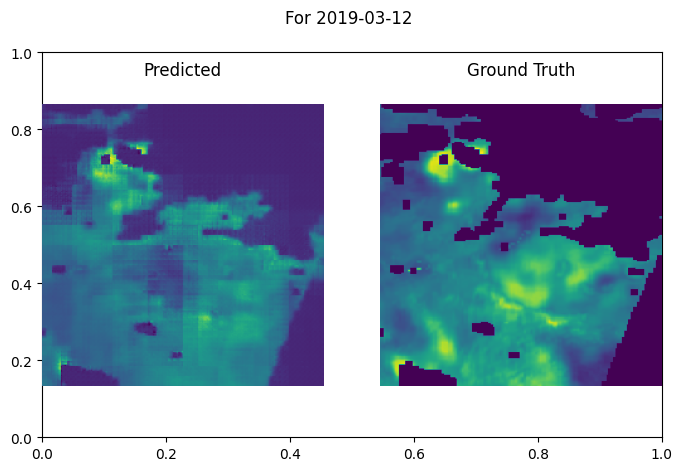

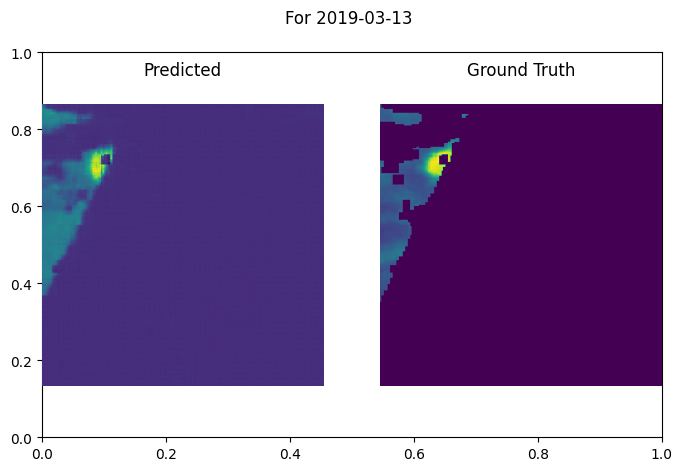

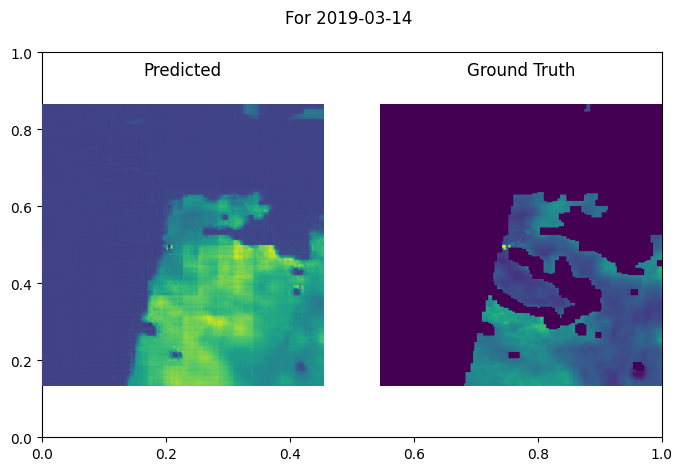

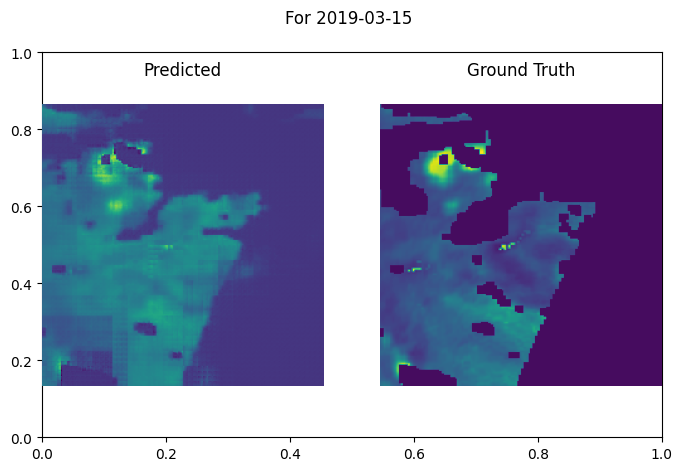

In [49]:
for i in range(len(x_sample)):
        # Extract predicted and ground truth for the current sample
        y_pred_sample = y_pred[i, 0].cpu().numpy()  # Convert to numpy array and move to CPU
        y_sample_vis = y_sample[i, 0].cpu().numpy()  # Convert to numpy array and move to CPU

        # Plot the predicted and ground truth images for the current sample
        plt.figure(figsize=(8, 5))
        plt.title(f'For {target_file_path[i]} \n')
        plt.subplot(1, 2, 1)
        plt.title(f'Predicted\n')  
        plt.imshow(y_pred_sample)
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.title(f'Ground Truth\n')  
        plt.imshow(y_sample_vis)
        plt.axis('off')

        plt.show()